In [ ]:
# The necessary file upload interface is initialized, allowing the user to provide the Kaggle API token.
# The 'kaggle.json' file contains authentication credentials required for accessing competition datasets.
from google.colab import files
files.upload()  # Upload 'kaggle.json' file here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mateuszjanowski","key":"35704b69998f85e4a12a958b864b4a3c"}'}

In [ ]:
# The authentication file is securely placed in the default Kaggle API configuration directory.
# File permissions are modified to restrict access for security reasons.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# After successful authentication, the dataset associated with the "Bike Sharing Demand" competition
# is downloaded using the official Kaggle API interface.
!kaggle competitions download -c bike-sharing-demand

  0% 0.00/189k [00:00<?, ?B/s]
100% 189k/189k [00:00<00:00, 652MB/s]


In [ ]:
# The downloaded ZIP archive is extracted into a dedicated local directory.
# This step ensures that individual CSV files can be easily accessed for further processing.
import zipfile
import os

with zipfile.ZipFile("bike-sharing-demand.zip", 'r') as zip_ref:
    zip_ref.extractall("bike_sharing_data")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
from datetime import datetime
from datetime import date
import calendar
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# The core data files ('train.csv' and 'test.csv') are read using the pandas library.
# The contents of each DataFrame are previewed to confirm successful import and to provide an overview of the structure.

df = pd.read_csv("bike_sharing_data/train.csv")

df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
df.drop(['casual','registered'],axis=1,inplace=True)

In [ ]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


# Data exploration

In [ ]:
df.shape

(10886, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   count       10886 non-null  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 850.6+ KB


In [ ]:
df.isnull().sum().sum()

np.int64(0)

In [ ]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,977.000000


#EDA

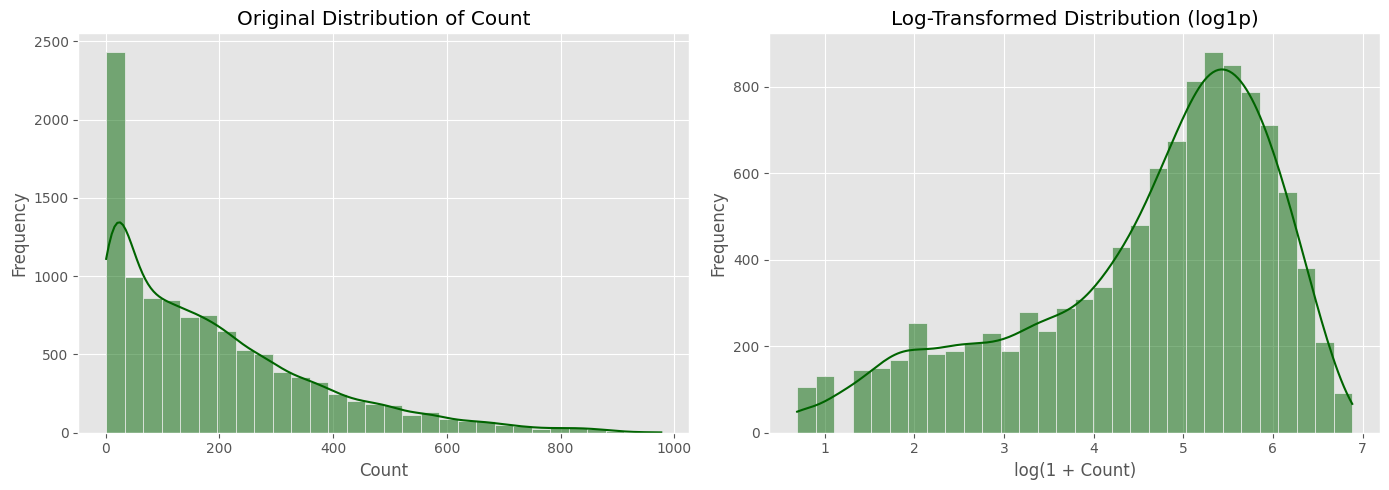

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original distribution with custom color
sns.histplot(df['count'], kde=True, ax=axes[0], bins=30, color='darkgreen')
axes[0].set_title('Original Distribution of Count')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Log-transformed distribution with custom color
sns.histplot(np.log1p(df['count']), kde=True, ax=axes[1], bins=30, color='darkgreen')
axes[1].set_title('Log-Transformed Distribution (log1p)')
axes[1].set_xlabel('log(1 + Count)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()


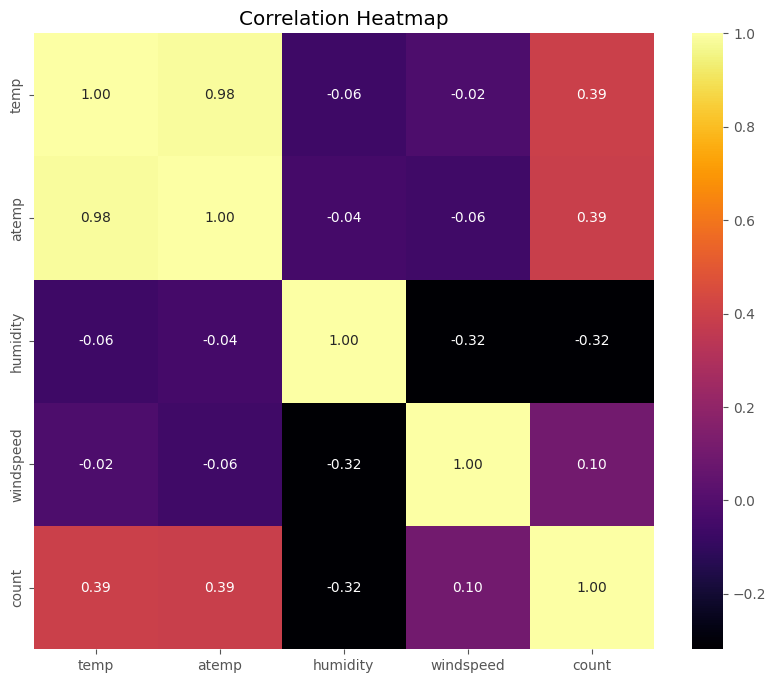

In [ ]:
correlation_variables = df[["temp", "atemp", "humidity", "windspeed", "count"]]
correlation_matrix = correlation_variables.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="inferno", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek

mapping = {0:'Mon', 1:'Tue', 2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df['dayofweek'] = df['dayofweek'].map(mapping)

df.drop('datetime', axis=1, inplace=True)

In [ ]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,date,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,2011-01-01,0,Sat
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,2011-01-01,1,Sat
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,2011-01-01,2,Sat
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,2011-01-01,3,Sat
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,2011-01-01,4,Sat


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   count       10886 non-null  int64  
 9   year        10886 non-null  int32  
 10  month       10886 non-null  int32  
 11  date        10886 non-null  object 
 12  hour        10886 non-null  int32  
 13  dayofweek   10886 non-null  object 
dtypes: float64(3), int32(3), int64(6), object(2)
memory usage: 1.0+ MB


In [ ]:
df.year.unique()

array([2011, 2012], dtype=int32)

In [ ]:
mapping_year = {2011:0, 2012:1}
df['year'] = df['year'].map(mapping_year)

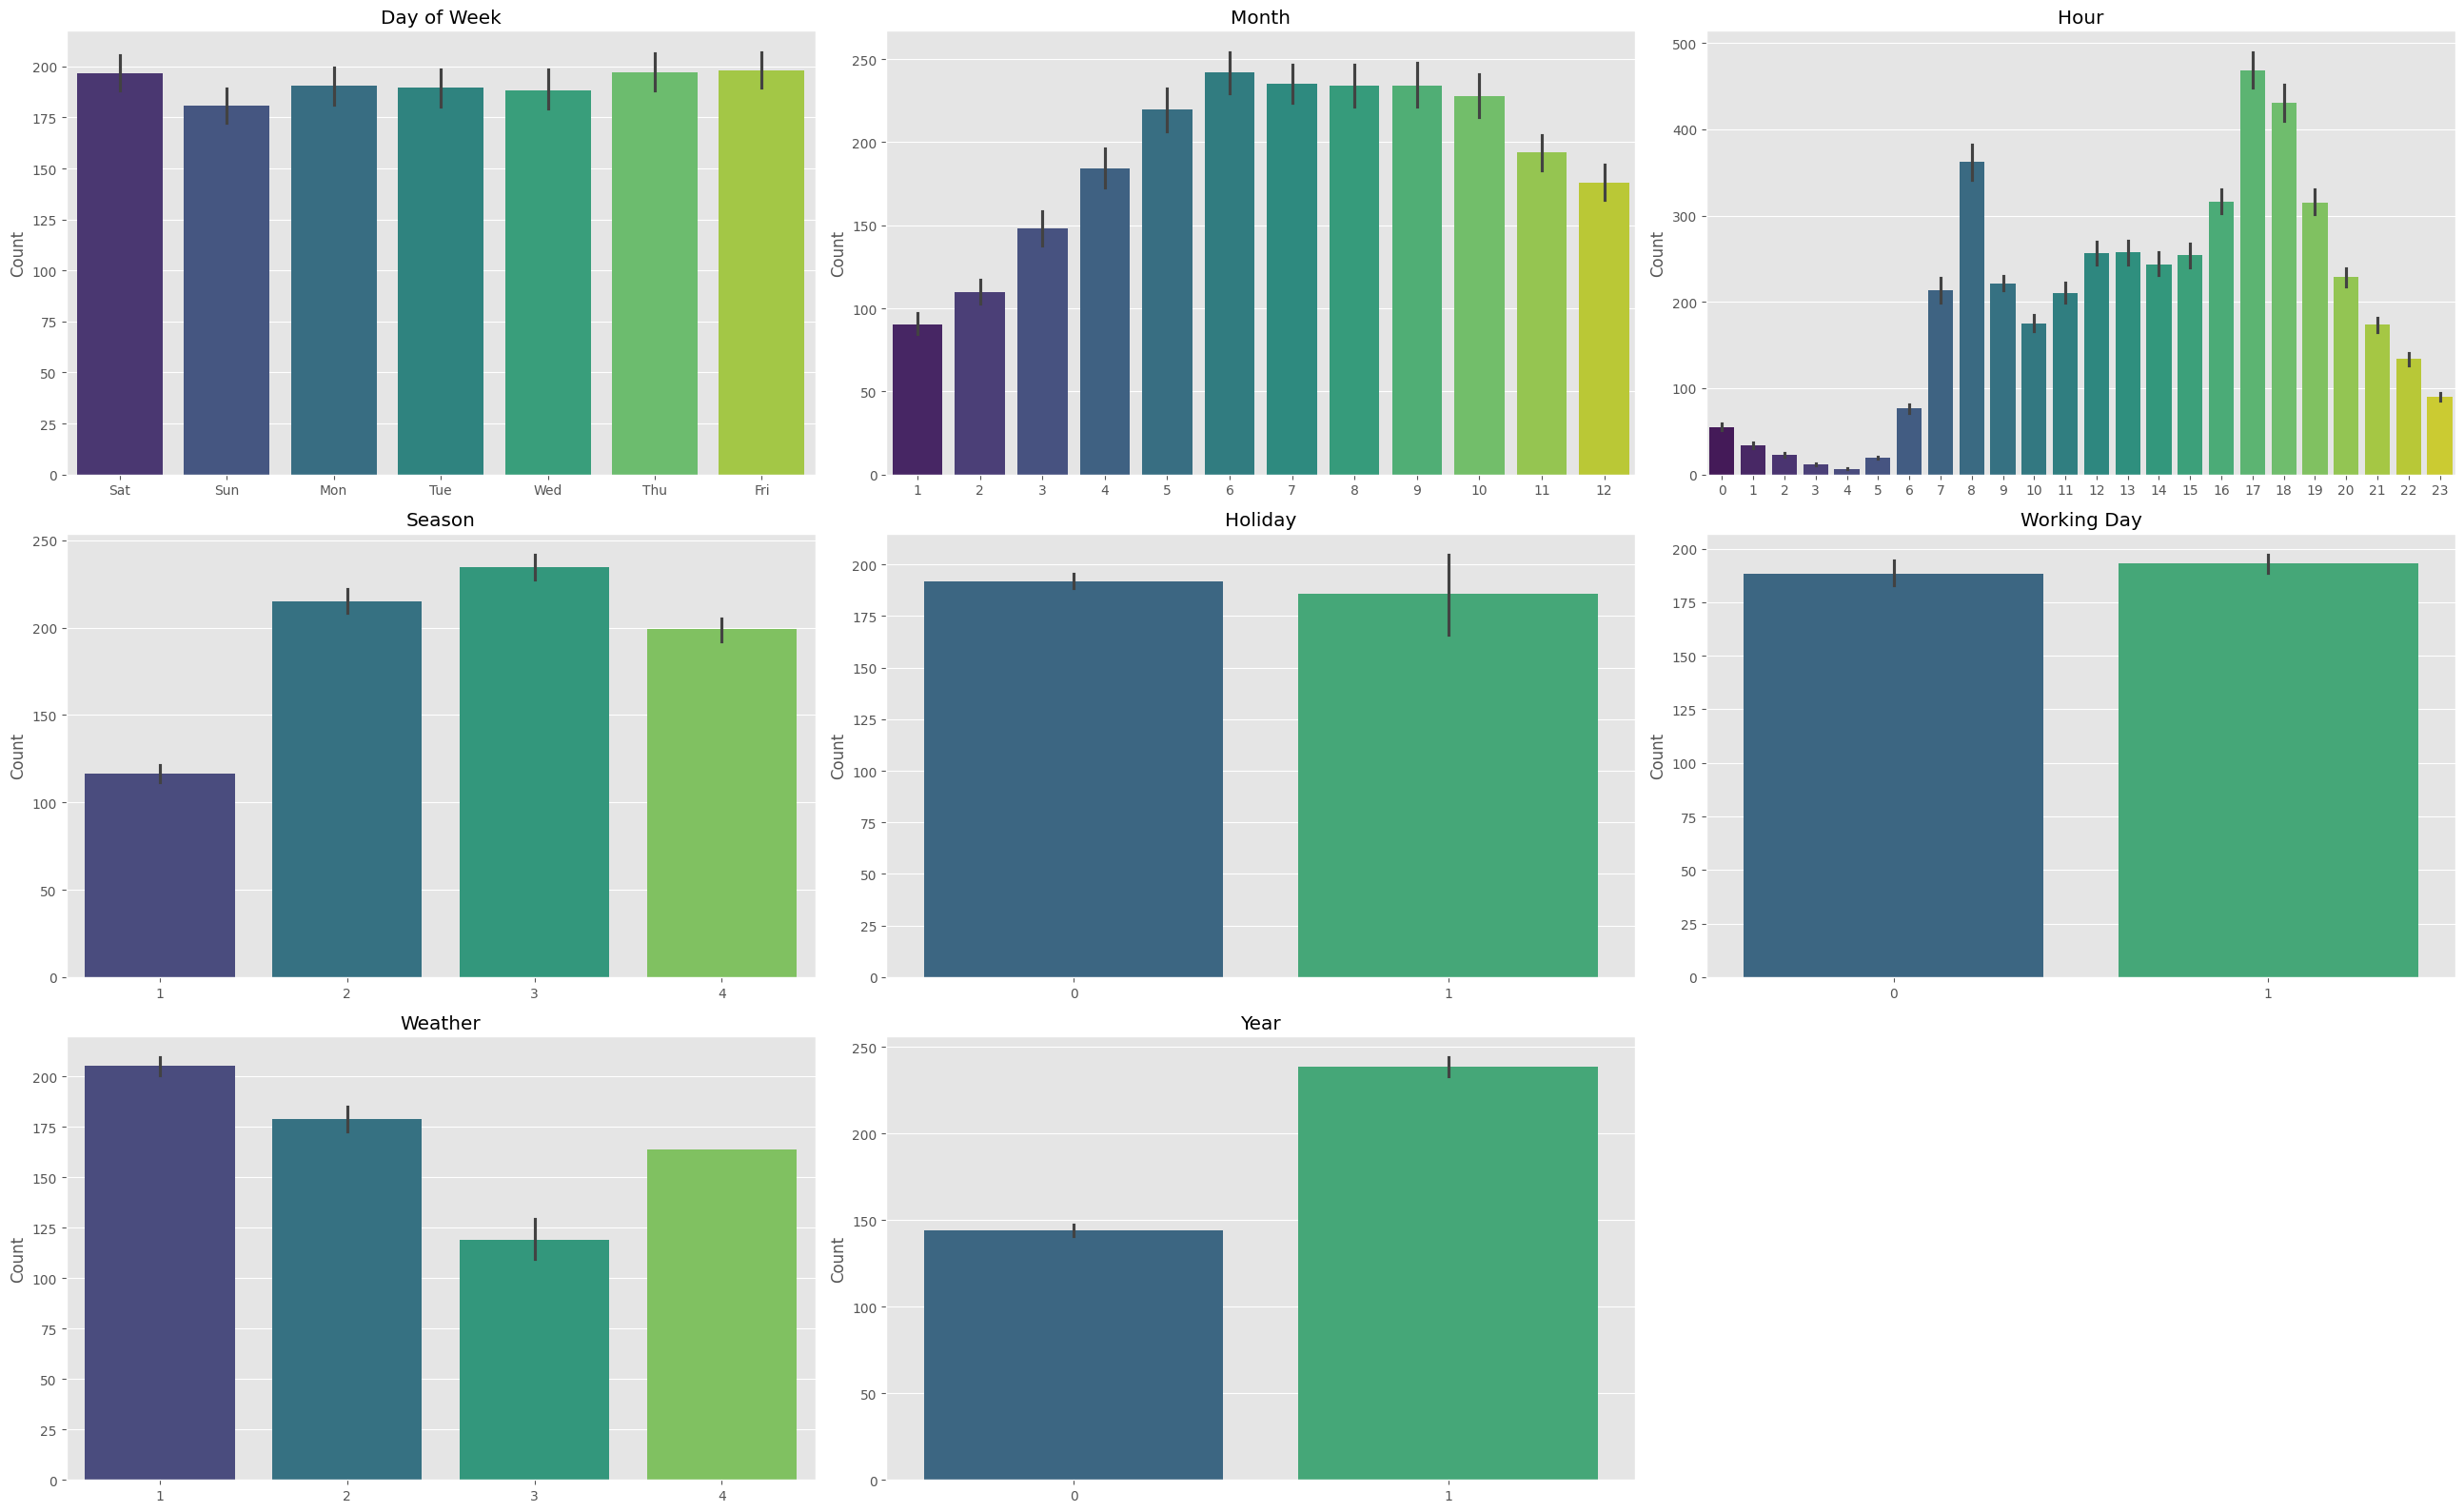

In [ ]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(26, 16))

# List of variables to plot and corresponding titles
plot_vars = ['dayofweek', 'month', 'hour', 'season', 'holiday', 'workingday', 'weather', 'year']
titles = ['Day of Week', 'Month', 'Hour', 'Season', 'Holiday', 'Working Day', 'Weather', 'Year']

# Iterate through axes and variables to create bar plots
for ax, var, title in zip(axes.flatten(), plot_vars, titles):
    sns.barplot(data=df, x=var, y='count', palette='viridis', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('Count')

# Remove the unused (last) subplot if fewer plots than axes
if len(plot_vars) < len(axes.flatten()):
    for i in range(len(plot_vars), len(axes.flatten())):
        fig.delaxes(axes.flatten()[i])  # delete the unused axis

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


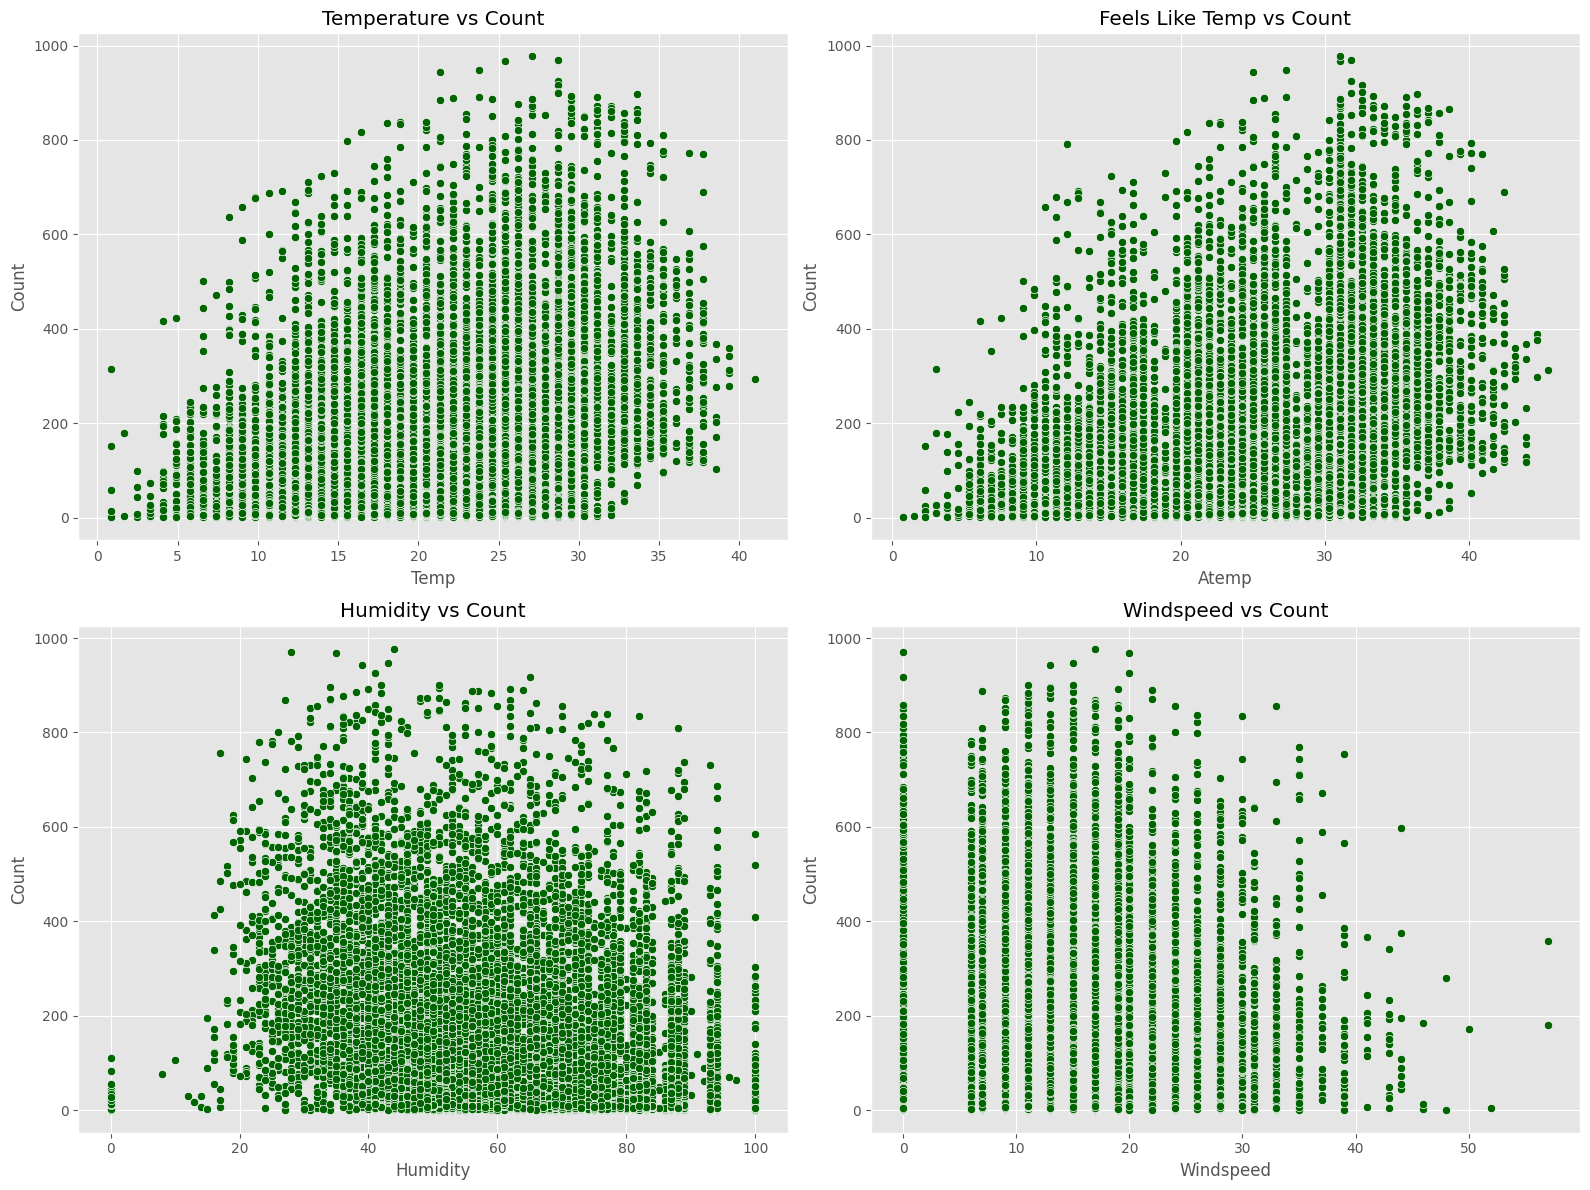

In [ ]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# List of variables to plot
plot_vars = ['temp', 'atemp', 'humidity', 'windspeed']
titles = ['Temperature vs Count', 'Feels Like Temp vs Count', 'Humidity vs Count', 'Windspeed vs Count']

# Create scatter plots
for ax, var, title in zip(axes.flatten(), plot_vars, titles):
    sns.scatterplot(data=df, x=var, y='count', color='darkgreen', ax=ax)
    ax.set_title(title)
    ax.set_xlabel(var.capitalize())
    ax.set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
df.drop(['atemp','date','dayofweek','year','windspeed','workingday'], axis=1, inplace=True)

In [ ]:
df.head()

,season,holiday,weather,temp,humidity,count,month,hour
0,1,0,1,9.84,81,16,1,0
1,1,0,1,9.02,80,40,1,1
2,1,0,1,9.02,80,32,1,2
3,1,0,1,9.84,75,13,1,3
4,1,0,1,9.84,75,1,1,4


In [ ]:
# Generate dummy variables
season = pd.get_dummies(df['season'], prefix='season', drop_first=True)
weather = pd.get_dummies(df['weather'], prefix='weather', drop_first=True)
holiday = pd.get_dummies(df['holiday'], prefix='holiday', drop_first=True)
month = pd.get_dummies(df['month'], prefix='month', drop_first=True)
hour = pd.get_dummies(df['hour'], prefix='hour', drop_first=True)

# Convert booleans to integers (True -> 1, False -> 0)
season = season.astype(int)
weather = weather.astype(int)
holiday = holiday.astype(int)
month = month.astype(int)
hour = hour.astype(int)

# Concatenate with original dataframe
df = pd.concat([df, season, weather, holiday, month, hour], axis=1)

# Drop original categorical columns
df.drop(['season', 'weather', 'holiday', 'month', 'hour'], axis=1, inplace=True)

# Preview the result
df.head()


,temp,humidity,count,season_2,season_3,season_4,weather_2,weather_3,weather_4,holiday_1,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,9.84,81,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9.02,80,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.02,80,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9.84,75,13,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9.84,75,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = df.drop('count',axis=1)
y = np.log(df['count'])

In [ ]:
X.head()

,temp,humidity,season_2,season_3,season_4,weather_2,weather_3,weather_4,holiday_1,month_2,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,9.84,81,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9.02,80,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.02,80,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9.84,75,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9.84,75,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def rmsle(y_true, y_pred):
# Adding a small constant to avoid log(0)
  return tf.sqrt(tf.reduce_mean(tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))))
#example usage
# model.compile(optimizer=’adam’, loss=’mse’, metrics=[rmsle])